<a href="https://colab.research.google.com/github/Nazchanel/Nazchanel/blob/main/Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import/Preprocessing (training)**



## Import/CSV processing

In [ ]:
import sys  
!{sys.executable} -m pip install contractions

     |████████████████████████████████| 321 kB 5.2 MB/s 
     |████████████████████████████████| 284 kB 42.4 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85452 sha256=216dff46d9fdf23197e864cdf07b4d65d0f17b56016eeccdc88b3b4d05d65fbf
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import seaborn as sns
import contractions as cot
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import re
import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
# Downloads library of stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from google.colab import drive
drive.mount('/content/drive') # Allows us to access the data
os.chdir("/content/drive/MyDrive/FakeNews") # Changes the directory to the folder with the csv files

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Mounted at /content/drive


In [ ]:
fn = pd.read_csv("Fake.csv")
tn = pd.read_csv("True.csv")
fn['truth'] = 0 # Makes a column of 0s marking the data false 
tn['truth'] = 1 # Makes a column of 1s marking the data true 

In [ ]:
tn.drop_duplicates(inplace=True)
fn.drop_duplicates(inplace=True)

In [ ]:
# Import and processing/cleaning of the dataframe
extra = pd.read_csv("/content/drive/MyDrive/archive8/politifact.csv")

# Drops the columns and rows that are not relevant
extra = extra.drop(columns=['Unnamed: 0', 'sources', 'sources_dates', 'sources_post_location', 'curator_name', 'curated_date', 'curators_article_title','curator_complete_article', 'curator_tags','sources_url'])
extra.drop_duplicates(inplace=True)
extra.dropna(inplace=True)

# Replaces the truths we want with their corresponding binary value 
extra['fact'].replace(['false', "pants-fire"], 0, inplace=True)
extra['fact'].replace(['true', 'mostly-true'], 1, inplace=True)

# Drops the rows of the truths we don't need 
extra.drop(extra.loc[extra['fact']=="half-true"].index, inplace=True)
extra.drop(extra.loc[extra['fact']=="barely-true"].index, inplace=True)
extra.drop(extra.loc[extra['fact']=="full-flop"].index, inplace=True)
extra.drop(extra.loc[extra['fact']=="half-flip"].index, inplace=True)
extra.drop(extra.loc[extra['fact']=="no-flip"].index, inplace=True)

extra.rename(columns={'sources_quote': 'title', 'fact':'truth'},inplace=True)

In [ ]:
# Removes the \n's in the DataFrame
def remove_lines(text):
  text = text.strip("\n")
  return text
extra['title'] = extra['title'].apply(lambda x:remove_lines(x))

extra['text'] = extra['title']
extra.head()

title  ...                                               text
0  Says Disneyland is enforcing a “no scream” pol...  ...  Says Disneyland is enforcing a “no scream” pol...
1  Video “proves 100% that President Joe Biden is...  ...  Video “proves 100% that President Joe Biden is...
2  “If you look at the average teacher pay compar...  ...  “If you look at the average teacher pay compar...
5  “Pelosi’s $1.9 trillion bailout gives EVERY fe...  ...  “Pelosi’s $1.9 trillion bailout gives EVERY fe...
6  “Black Lives Matter of Atlanta Charged with Wi...  ...  “Black Lives Matter of Atlanta Charged with Wi...

[5 rows x 3 columns]

In [ ]:
# IMPORTANT: Balances the data; making the value higher will lean the program 
# to predict true, lower is the opposite

fn = fn[:-4000]
fn.head()

title  ... truth
0   Donald Trump Sends Out Embarrassing New Year’...  ...     0
1   Drunk Bragging Trump Staffer Started Russian ...  ...     0
2   Sheriff David Clarke Becomes An Internet Joke...  ...     0
3   Trump Is So Obsessed He Even Has Obama’s Name...  ...     0
4   Pope Francis Just Called Out Donald Trump Dur...  ...     0

[5 rows x 5 columns]

In [ ]:
fn.rename(columns={0: "title", 1: "text", 2: "subject", 3: "date", 4: "truth" }, inplace=True)

In [ ]:
news = pd.concat([tn, fn, extra], axis=0, ignore_index=True) # Combines the dataframes so its easier to work with


In [ ]:
news.drop_duplicates(inplace=True) # Drops any leftover duplicates

In [ ]:
news["truth"].value_counts()

1    26850
0    26388
Name: truth, dtype: int64

In [ ]:
news.head()
os.chdir("/content/")
news.to_csv()

In [ ]:
news.to_csv('fiilename.csv', chunksize=100000)


In [ ]:
news.head(2)

## Preprocessing


In [ ]:
def remove_contractions(text):
  fixed_word = []
  for word in text.split():
    fixed_word.append(cot.fix(word))
  counter = 0
  for i in fixed_word:
    if i != fixed_word[0]:
      counter+=1
    if i == "you.S.":
      fixed_word[counter] = "u.s."
    if i == "yous":
      fixed_word[counter] = "u.s."
  fixed_whole =' '.join(fixed_word)
  return fixed_whole

# Applies the functions with lambda to do the stated function
news['title_wo_contra']=news['title'].apply(lambda x: remove_contractions(x))
news['text_wo_contra']=news['text'].apply(lambda x: remove_contractions(x))
news.head()

In [ ]:
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

# Applies the functions with lambda to do the stated function
news['title_wo_punct']=news['title_wo_contra'].apply(lambda x: remove_punctuation(x))
news['text_wo_punct']=news['text_wo_contra'].apply(lambda x: remove_punctuation(x))
news.head()

title  ...                                      text_wo_punct
0  As U.S. budget fight looms, Republicans flip t...  ...  WASHINGTON Reuters  The head of a conservative...
1  U.S. military to accept transgender recruits o...  ...  WASHINGTON Reuters  Transgender people will be...
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...  WASHINGTON Reuters  The special counsel invest...
3  FBI Russia probe helped by Australian diplomat...  ...  WASHINGTON Reuters  Trump campaign adviser Geo...
4  Trump wants Postal Service to charge 'much mor...  ...  SEATTLEWASHINGTON Reuters  President Donald Tr...

[5 rows x 9 columns]

In [ ]:
def remove_stopwords(text):
    text = text.split()
    text=[word for word in text if word not in stopword]
    text= ' '.join(text)
    return text
    
# Applies the functions with lambda to do the stated function
news['title_wo_stopwords'] = news['title_wo_punct'].apply(lambda x: remove_stopwords(x.lower()))
news['text_wo_stopwords'] = news['text_wo_punct'].apply(lambda x: remove_stopwords(x.lower()))

news.head()

title  ...                                  text_wo_stopwords
0  As U.S. budget fight looms, Republicans flip t...  ...  washington reuters head conservative republica...
1  U.S. military to accept transgender recruits o...  ...  washington reuters transgender people allowed ...
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...  washington reuters special counsel investigati...
3  FBI Russia probe helped by Australian diplomat...  ...  washington reuters trump campaign adviser geor...
4  Trump wants Postal Service to charge 'much mor...  ...  seattlewashington reuters president donald tru...

[5 rows x 11 columns]

In [ ]:
# Removes any formatted quotation marks that the remove contractions function 
# didn't remove

def remove_quotemarks(text):
  text = text.replace('“', "")
  text = text.replace('’', "")
  text = text.replace('”', "")
  return text
 
news['filtered_title'] =news['title_wo_stopwords'].apply(lambda x:remove_quotemarks(x)) 
news['filtered'] =news['text_wo_stopwords'].apply(lambda x:remove_quotemarks(x)) 
news['filtered']

0        washington reuters head conservative republica...
1        washington reuters transgender people allowed ...
2        washington reuters special counsel investigati...
3        washington reuters trump campaign adviser geor...
4        seattlewashington reuters president donald tru...
                               ...                        
53233    house health care bill something like 2 percen...
53234    ronald reagan faced even worse recession curre...
53235          mccain campaign elaborate obamas ties acorn
53236    obama admitted cap trade plan would electricit...
53237    says could take stimulus money required univer...
Name: filtered, Length: 53238, dtype: object

In [ ]:
# Deletes all the excess columns and sets the title equal to the preprocessed version 

news["joined_title"] = news["filtered_title"]
news = news.drop(["title_wo_contra","title_wo_punct","title_wo_stopwords", "filtered_title"], axis=1)
news["joined_text"] = news["filtered"]
news = news.drop(["text_wo_contra","text_wo_punct","text_wo_stopwords", "filtered"], axis=1)
news.head(10)

title  ...                                        joined_text
0  As U.S. budget fight looms, Republicans flip t...  ...  washington reuters head conservative republica...
1  U.S. military to accept transgender recruits o...  ...  washington reuters transgender people allowed ...
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...  washington reuters special counsel investigati...
3  FBI Russia probe helped by Australian diplomat...  ...  washington reuters trump campaign adviser geor...
4  Trump wants Postal Service to charge 'much mor...  ...  seattlewashington reuters president donald tru...
5  White House, Congress prepare for talks on spe...  ...  west palm beach flawashington reuters white ho...
6  Trump says Russia probe will be fair, but time...  ...  west palm beach fla reuters president donald t...
7  Factbox: Trump on Twitter (Dec 29) - Approval ...  ...  following statements posted verified twitter a...
8         Trump on Twitter (Dec 28) - Global Warming  ...  following statements posted verified twitter a...
9  Alabama official to certify Senator-elect Jone...  ...  washington reuters alabama secretary state joh...

[10 rows x 7 columns]

## Visualization

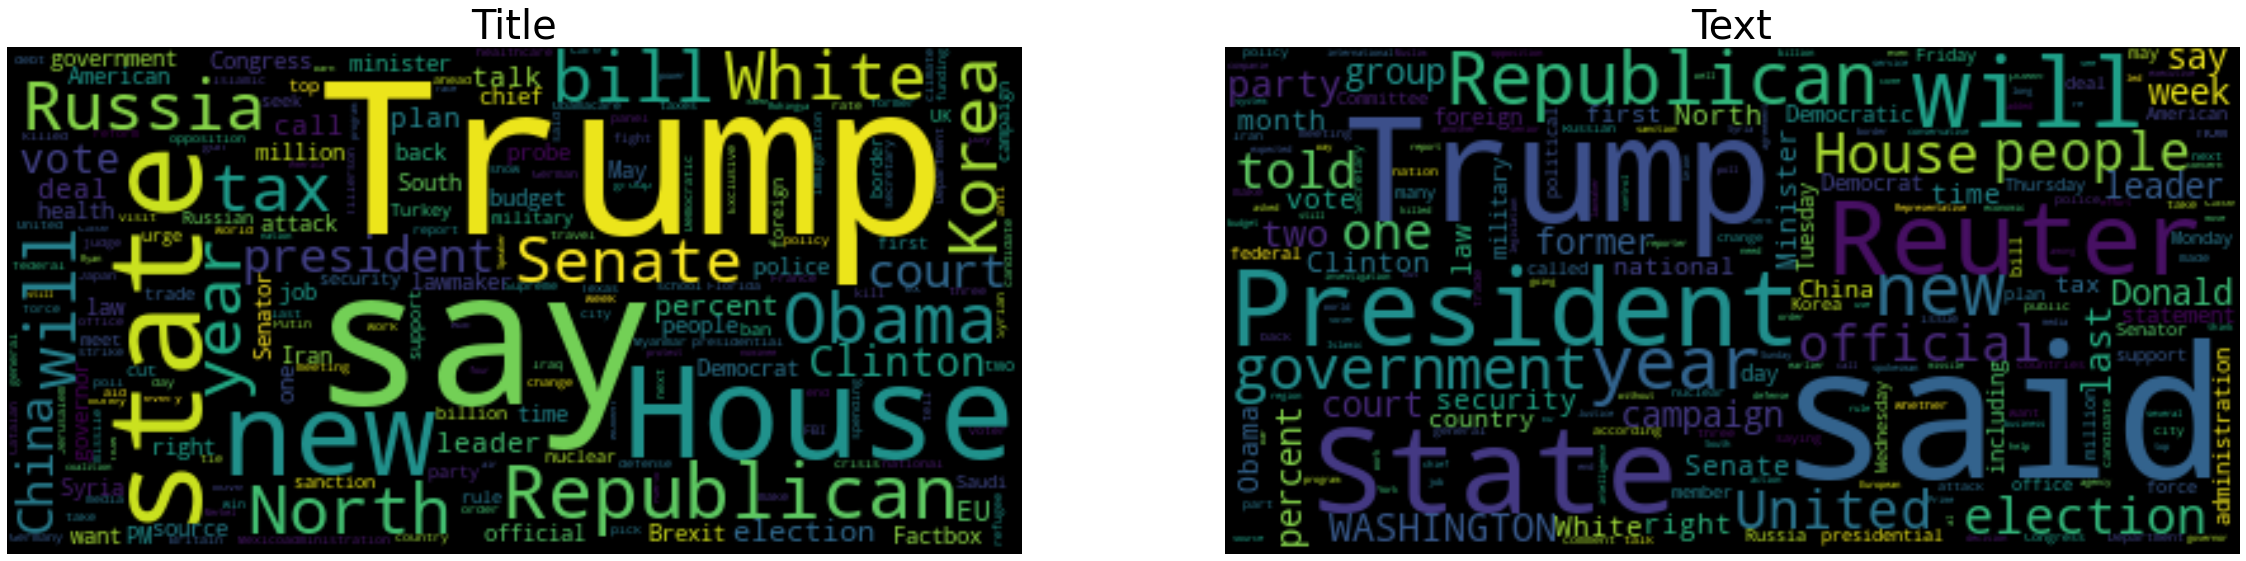

In [ ]:
# Wordcloud of title, text in True news
import wordcloud
# Cleaned dataframe of True labels
df_true = news[news.truth == 1]

title_true = " ".join(tit for tit in df_true['title'])
text_true = " ".join(txt for txt in df_true['text'])

plt.figure(figsize=(40, 30))

# Title
title_cloud = wordcloud.WordCloud(collocations=False, background_color='black').generate(title_true)
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Title", fontsize=40)
plt.imshow(title_cloud, interpolation='bilinear')

# Title
text_cloud = wordcloud.WordCloud(collocations=False, background_color='black').generate(text_true)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Text", fontsize=40)
plt.imshow(text_cloud, interpolation='bilinear')


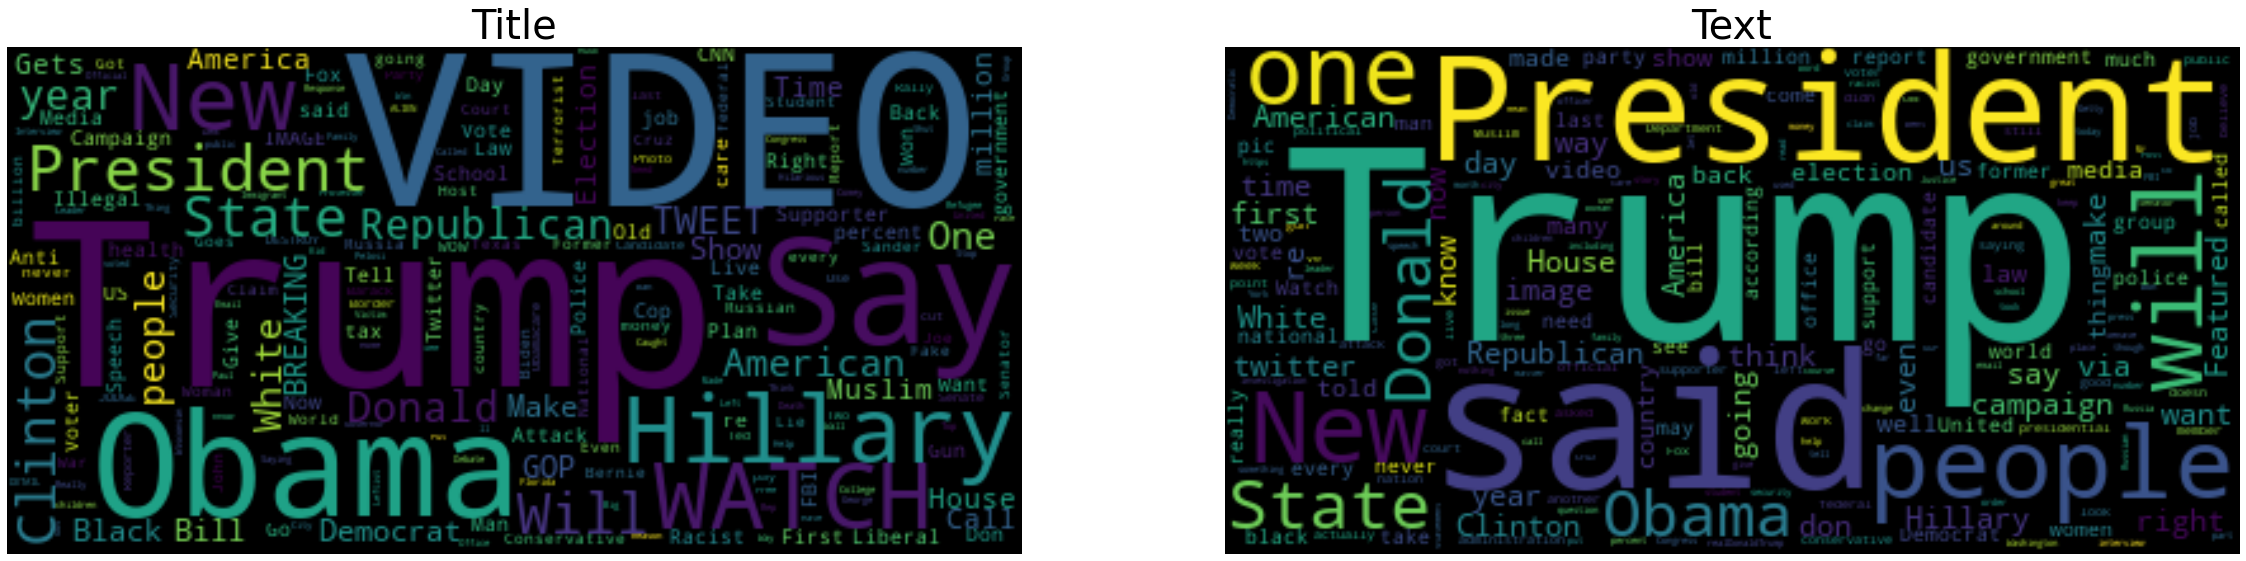

In [ ]:
# Wordcloud of title, text in Fake news

# Cleaned dataframe of Fake labels

df_fake = news[news.truth == 0]

title_fake = " ".join(tit for tit in df_fake['title'])
text_fake = " ".join(txt for txt in df_fake['text'])

plt.figure(figsize=(40, 30))

# Title
title_cloud = wordcloud.WordCloud(collocations=False, background_color='black').generate(title_fake)
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Title", fontsize=40)
plt.imshow(title_cloud, interpolation='bilinear')

# Title
text_cloud = wordcloud.WordCloud(collocations=False, background_color='black').generate(text_fake)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Text", fontsize=40)
plt.imshow(text_cloud, interpolation='bilinear')

# **Model**

## **Vectorization/Model**

In [ ]:
y = news['truth']
y = y.astype('int') # Some of the y values are "objects", so this converts it to int
X = news['joined_text']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #Splits the data


In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Pipeline makes it easy to predict; no direct vectorization needed
# Can be all applied in one line

text_clf = Pipeline([('vect', TfidfVectorizer(ngram_range=(2,3), binary=True)),
                  ('tfidf', TfidfTransformer()),
                  ('clf', MultinomialNB())])


text_clf = text_clf.fit(X_train, y_train)


##**ML Model Scoring**

In [ ]:
# Train score
text_clf.score(X_train, y_train)


0.9869218126320732

In [ ]:
# Test score
text_clf.score(X_test, y_test)

0.862885048835462

## **Precision and Recall Visualization**

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
y_predict_train = text_clf.predict(X_train)
y_predict_test = text_clf.predict(X_test)

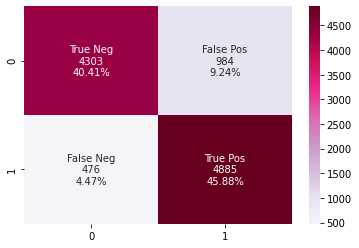

In [ ]:
cm = confusion_matrix(y_test, y_predict_test)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='PuRd')

In [ ]:
cr = classification_report(y_test, y_predict_test, output_dict= True)
cr = pd.DataFrame(cr).transpose()
cr

precision    recall  f1-score       support
0              0.900398  0.813883  0.854957   5287.000000
1              0.832339  0.911211  0.869991   5361.000000
accuracy       0.862885  0.862885  0.862885      0.862885
macro avg      0.866368  0.862547  0.862474  10648.000000
weighted avg   0.866132  0.862885  0.862526  10648.000000

# **Input**

## **Input (manual)**

In [ ]:
# Manual input
# Enter values into list
text_sample = ["We have a record 9.3 million job openings in the U.S.", "You can vote below the age of 18", "Hillary Clinton won presidency"]
df = pd.DataFrame(text_sample, columns= ['text'])
df2 = df.copy()
df

text
0  We have a record 9.3 million job openings in t...
1                   You can vote below the age of 18
2                     Hillary Clinton won presidency

In [ ]:
text_clf.predict(text_sample)

array([1, 1, 1])

## **Input (scraped)**

In [ ]:
from bs4 import BeautifulSoup
import urllib.request,sys,time
import requests
import urllib

In [ ]:
page = ""

# Type of news Input statement
# Try and except to make sure user gives an integer value
try:
  ton = int(input("What type of news to input into the model?:\n1: True\n2: Mostly True\n3: Half True\n4: Barely True\n5: False\n6: Extremely False\n"))
except ValueError:
  print("Enter a number!")
if ton == 1:
  page = "true"
elif ton == 2:
  page= 'mostly-true'
elif ton == 3:
  page= 'half-true'
elif ton == 4:
  page= 'barely-true'
elif ton == 5:
  page = 'false'
elif ton == 6:
  page = "pants-fire"
else:
  print("Not valid!")

# Append the sub-url that the user choses to the parent url

url = 'https://www.politifact.com/factchecks/list/?ruling='+ str(page) 

print("Data source: "+ url)

In [ ]:
def getdata(url): 
    r = requests.get(url) 
    return r.text 

page = getdata(url)
soup = BeautifulSoup(page, "html.parser")


data = '' 
lst = []

# Finds all the text that are located in the element that the claims are located
for data in soup.find_all("div",attrs={"class":"m-statement__quote"}): 
  lst.append(data.get_text()) 

new_list = [s.replace("\n", "") for s in lst]
res = []

# Filters out duplicates
for i in new_list:
    if i not in res:
        res.append(i)

In [ ]:
# Makes the list that will show the values of the truth in the DataFrame
if ton == 1:
  cat = ['true']
elif ton == 2:
  cat= ['mostly true']
elif ton == 3:
  cat= ['half true']
elif ton == 4:
  cat= ['barely true']
elif ton == 5:
  cat = ['false']
elif ton == 6:
  cat = ["extremely false"]
else:
  print("invalid")
cat*=len(res) # 


# Converts the lists of text and truths of that text into a DataFrame
d = {'text':res,'truth':cat}
df = pd.DataFrame(data = d)

In [ ]:
# Creates a copy so we can access the original later to display
df1 = df.copy()

# **Prediction**

## **Preprocessing (Input)**

same functions with slightly different changes

In [ ]:
def remove_contractions(text):
  fixed_word = []
  for word in text.split():
    fixed_word.append(cot.fix(word))
  counter = 0
  for i in fixed_word:
    if i != fixed_word[0]:
      counter+=1
    if i == "you.S.":
      fixed_word[counter] = "u.s."
    if i == "yous":
      fixed_word[counter] = "u.s."
  fixed_whole =' '.join(fixed_word)
  return fixed_whole


df['text_wo_contra']=df['text'].apply(lambda x: remove_contractions(x))

In [ ]:
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct
df['text_wo_punct']=df['text_wo_contra'].apply(lambda x: remove_punctuation(x))

In [ ]:
def remove_stopwords(text):
    text = text.split()
    text=[word for word in text if word not in stopword]
    text= ' '.join(text)
    return text

df['text_wo_punct_wo_stopwords'] = df['text_wo_punct'].apply(lambda x: remove_stopwords(x.lower()))
df.head()

In [ ]:
def remove_quotemarks(text):
  text = text.replace('“', "")
  text = text.replace('’', "")
  text = text.replace('”', "")
  return text
df['filtered'] =df['text_wo_punct_wo_stopwords'].apply(lambda x:remove_quotemarks(x)) 
df['filtered']

In [ ]:
df["joined"] = df["filtered"]
df = df.drop(["text_wo_contra","text_wo_punct","text_wo_punct_wo_stopwords", "filtered"], axis=1)
df.head(10)

## **Model, Vectorization, Prediction, and Confusion Matrix** (Scraped)

In [ ]:
tmp = df["joined"]

text_sample = pd.Series.tolist(tmp) # Makes the sample text a list so it can be accessed


sample_predict = text_clf.predict(text_sample)

# The predicted values become a list so they can be inputed into the DataFrame

df1['predicted'] = sample_predict.tolist()



df1.head(6)

In [ ]:
df3 = df1.copy()

# Replaces the values with their corresponding binary value
df3['truth'].mask(df3['truth'] == 'false', 0, inplace=True)
df3['truth'].mask(df3['truth'] == 'barely true', 0, inplace=True)
df3['truth'].mask(df3['truth'] == 'extremely false', 0, inplace=True)
df3['truth'].mask(df3['truth'] == 'half true', 0, inplace=True)
df3['truth'].mask(df1['truth'] == 'true', 1, inplace=True)
df3['truth'].mask(df1['truth'] == 'mostly true', 1, inplace=True)
a = df3['truth'].tolist()
b = df3['predicted'].tolist()



In [ ]:
true_negative = 0
false_negative = 0
true_positive = 0
false_positive = 0

# Gets the values of the confusion matrix
for i, j in zip(a, b):
  if i == j and i == 0:
    true_negative+=1
  elif i == j and i == 1:
    true_positive+=1
  elif i != j and j == 0:
    false_negative+=1
  elif i != j and j == 1:
    false_positive+=1


In [ ]:
# Creates the blank confusion matrix
matrix = pd.DataFrame(columns=['negative', 'positive'], index=['negative', 'positive'])

# Sets the values of the previous cell to their correct position on the matrix
matrix['negative']['negative'] = true_negative
matrix['positive']['positive'] = true_positive
matrix['negative']['positive'] = false_negative
matrix['positive']['negative'] = false_positive

# NOTE: Columns is predicted and indexs are actual value
matrix

In [ ]:
df1['predicted'].mask(df1['predicted'] == 0, 'false', inplace=True)
df1['predicted'].mask(df1['predicted'] == 1, 'true', inplace=True)
df1.head()

In [ ]:
df1.iloc[3][0]

##  **Model, Vectorization, Prediction** (Manual)

In [ ]:
tmp = df["joined"]
text_sample = pd.Series.tolist(tmp)

sample_predict = text_clf.predict(text_sample)

df2['predicted'] = sample_predict.tolist()
df2['predicted'].mask(df2['predicted'] == 0, 'false', inplace=True)
df2['predicted'].mask(df2['predicted'] == 1, 'true', inplace=True)

df2